# MIMIC II Waveform exloration

In [1]:
import sys
from pathlib import Path
#!pip install wfdb==4.0.0
import wfdb

In [2]:
database_name = 'mimic3wdb-matched/1.0'

In [3]:
# each subject may be associated with multiple records
subjects = wfdb.get_record_list(database_name)
print(f"The '{database_name}' database contains data from {len(subjects)} subjects")

# set max number of records to load
max_records_to_load = 200

The 'mimic3wdb-matched/1.0' database contains data from 10282 subjects


In [4]:
# iterate the subjects to get a list of records
records = []
subject = subjects[0]
studies = wfdb.get_record_list(f'{database_name}/{subject}')
for study in studies:
        records.append(Path(f'{subject}{study}'))
        # stop if we've loaded enough records
        if len(records) >= max_records_to_load:
            print("Reached maximum required number of records.")
            break

print(f"Loaded {len(records)} records from the '{database_name}' database for subject {subject}.")

Loaded 10 records from the 'mimic3wdb-matched/1.0' database for subject p00/p000020/.


In [6]:
# format and print first five records
first_five_records = [str(x) for x in records[0:5]]
first_five_records = "\n - ".join(first_five_records)
print(f"First five records: \n - {first_five_records}")

print("""
Note the formatting of these records:
 - intermediate directory ('p100' in this case)
 - subject identifier (e.g. 'p10014354')
 - record identifier (e.g. '81739927'
 """)

First five records: 
 - p00/p000020/p000020-2183-04-28-17-47
 - p00/p000020/p000020-2183-04-28-17-47n
 - p00/p000020/3544749_0001
 - p00/p000020/3544749_0002
 - p00/p000020/3544749_0003

Note the formatting of these records:
 - intermediate directory ('p100' in this case)
 - subject identifier (e.g. 'p10014354')
 - record identifier (e.g. '81739927'
 


In [7]:
# Specify the 4th record (note, in Python indexing begins at 0)
idx = 3
record = records[idx]
record_dir = f'{database_name}/{record.parent}'
print("PhysioNet directory specified for record: {}".format(record_dir))

PhysioNet directory specified for record: mimic3wdb-matched/1.0/p00/p000020


In [8]:
record_name = record.name
print("Record name: {}".format(record_name))

Record name: 3544749_0002


In [9]:
record_data = wfdb.rdheader(record_name, pn_dir=record_dir, rd_segments=True)
remote_url = "https://physionet.org/content/" + record_dir + "/" + record_name + ".hea"
print(f"Done: metadata loaded for record '{record_name}' from the header file at:\n{remote_url}")

Done: metadata loaded for record '3544749_0002' from the header file at:
https://physionet.org/content/mimic3wdb-matched/1.0/p00/p000020/3544749_0002.hea


In [10]:
print(record_data.__dict__)

{'record_name': '3544749_0002', 'n_sig': 4, 'fs': 125, 'counter_freq': None, 'base_counter': None, 'sig_len': 124, 'base_time': datetime.time(17, 48, 30, 714000), 'base_date': None, 'comments': [], 'sig_name': ['II', 'AVF', 'ABP', 'PAP'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['3544749_0002.dat', '3544749_0002.dat', '3544749_0002.dat', '3544749_0002.dat'], 'fmt': ['80', '80', '80', '80'], 'samps_per_frame': [1, 1, 1, 1], 'skew': [None, None, None, None], 'byte_offset': [None, None, None, None], 'adc_gain': [1.0, 1.0, 1.25, 1.0], 'baseline': [0, 0, -100, 0], 'units': ['mV', 'mV', 'mmHg', 'mmHg'], 'adc_res': [8, 8, 8, 8], 'adc_zero': [0, 0, 0, 0], 'init_value': [16, 16, -19, 16], 'checksum': [215, 960, -1713, -3281], 'block_size': [0, 0, 0, 0]}


In [14]:
print(f"- Number of signals: {record_data.n_sig}".format())
print(f"- Signal names: {record_data.sig_name}".format())
print(f"- Number of samples: {record_data.sig_len}".format())
print(f"- Duration: {record_data.sig_len/(record_data.fs):.1f} seconds") 
print(f"- Base sampling frequency: {record_data.fs} Hz")

- Number of signals: 4
- Signal names: ['II', 'AVF', 'ABP', 'PAP']
- Number of samples: 124
- Duration: 1.0 seconds
- Base sampling frequency: 125 Hz


## Data Exploration recorded waveforms durations and sampling frequencies

In [ ]:
# get overall signal length recorded for one patient
aggregated_stats = []

stats = []
signals = []
for record in records:
    if not(record.name[-1] == 'n'):
        record_data = wfdb.rdheader(record.name, pn_dir=f'{database_name}/{record.parent}')

        if record_data.sig_name:
            signals = signals + record_data.sig_name

            stats.append({
                'subject': record.name,
                'record_id': record.name,
                'signals': record_data.sig_name,
                'duration_seconds': record_data.sig_len / record_data.fs,
                'sampling_frequency': record_data.fs
            })



for signal in set(signals):
    # calculate based on whether records are consecutiv or not, you can tell by int(record_id.split('_')[1])
    record_durations = [[int(s['record_id'].split('_')[1]), s['duration_seconds']] for s in stats if signal in s['signals']]

    # add dration for elements wehre the first enry is consecutive
    total_durations = []
    duration = 0
    for e in range(0, len(record_durations)-1):
        record_id, duration_seconds = record_durations[e]
        if e == 0:
            duration = duration_seconds

        if record_id + 1 == record_durations[e + 1][0]:
            duration += record_durations[e+1][1]
        else:
            total_durations.append(duration)
            duration = record_durations[e+1][1]
    
    total_durations.append(duration)


    for total_duration in total_durations:
        aggregated_stats.append({
            'subject': subject,
            'signal': signal,
            'total_duration_seconds': total_duration,
            'sampling_frequency': record_data.fs
        })


Signal 'AVF' has a total durations of [78900.0] seconds across all records.
Signal 'PAP' has a total durations of [56820.0] seconds across all records.
Signal 'ABP' has a total durations of [56820.0, 240.0] seconds across all records.
Signal 'II' has a total durations of [78900.0] seconds across all records.
Aggregated stats for subject p00/p000020/:
[{'subject': 'p00/p000020/', 'signal': 'AVF', 'total_duration_seconds': 78900.0, 'sampling_frequency': 125}, {'subject': 'p00/p000020/', 'signal': 'PAP', 'total_duration_seconds': 56820.0, 'sampling_frequency': 125}, {'subject': 'p00/p000020/', 'signal': 'ABP', 'total_duration_seconds': 56820.0, 'sampling_frequency': 125}, {'subject': 'p00/p000020/', 'signal': 'ABP', 'total_duration_seconds': 240.0, 'sampling_frequency': 125}, {'subject': 'p00/p000020/', 'signal': 'II', 'total_duration_seconds': 78900.0, 'sampling_frequency': 125}]


In [138]:
import pickle
# save the aggregated stats to a file
output_file = 'mimic3wdb-matched_waveform_signals_duration.pkl'

In [144]:
aggregated_stats = []

i = 0
for subject in subjects:
    studies = wfdb.get_record_list(f'{database_name}/{subject}')
    records = []
    for study in studies:
            records.append(Path(f'{subject}{study}'))
    
    signals = []
    stats = []
    for record in records:
            if not(record.name[-1] == 'n'):
                record_data = wfdb.rdheader(record.name, pn_dir=f'{database_name}/{record.parent}')

                if record_data.sig_name:
                    signals = signals + record_data.sig_name

                    stats.append({
                        'subject': record.name,
                        'record_id': record.name,
                        'signals': record_data.sig_name,
                        'duration_seconds': record_data.sig_len / record_data.fs,
                        'sampling_frequency': record_data.fs
                    })


    for signal in set(signals):
        # calculate based on whether records are consecutiv or not, you can tell by int(record_id.split('_')[1])
        record_durations = [[int(s['record_id'].split('_')[1]), s['duration_seconds']] for s in stats if signal in s['signals']]

        # add dration for elements wehre the first enry is consecutive
        total_durations = []
        duration = 0
        for e in range(0, len(record_durations)-1):
            record_id, duration_seconds = record_durations[e]
            if e == 0:
                duration = duration_seconds

            if record_id + 1 == record_durations[e + 1][0]:
                duration += record_durations[e+1][1]
            else:
                total_durations.append(duration)
                duration = record_durations[e+1][1]
                    
            total_durations.append(duration)


            for total_duration in total_durations:
                aggregated_stats.append({
                            'subject': subject,
                            'signal': signal,
                            'total_duration_seconds': total_duration,
                            'sampling_frequency': record_data.fs
                })
    i += 1
    if i % 1000 == 0:
        print(f"Processed {i} subjects out of {len(subjects)}")

    # save to pickle file
    with open(output_file, 'wb') as f:
            pickle.dump(aggregated_stats, f)

KeyboardInterrupt: 

### for numerics

In [13]:
import pandas as pd

In [ ]:
# get overall signal length recorded for one patient

#stats = []
#i = 0
#for subject in subjects:
#    studies = wfdb.get_record_list(f'{database_name}/{subject}')
#    records = []
#    for study in studies:
#            records.append(Path(f'{subject}{study}'))
#    for record in records:
#        if record.name[-1] == 'n':
#            record_data = wfdb.rdheader(record.name, pn_dir=f'{database_name}/{record.parent}')
#            signals = record_data.sig_name
#
#            for signal in signals:
#                stats.append({
#                    'subject': subject,
#                    'record_id': record.name,
#                    'signal': signal,
#                    'duration_seconds': record_data.sig_len / record_data.fs,
#                    'sampling_frequency': record_data.fs
#                })
#    
#    i = i+1
#
#    if i % 500 == 0:
#        print(f"Processed {i} subjects out of {len(subjects)}")

#numerics_stats_df = pd.DataFrame(stats)
# save the stats to a CSV file
#numerics_stats_df.to_csv('mimic3wdb-matched_numerics_signals_duration.csv', index=False)


Processed 500 subjects out of 10282
Processed 1000 subjects out of 10282
Processed 1500 subjects out of 10282
Processed 2000 subjects out of 10282
Processed 2500 subjects out of 10282
Processed 3000 subjects out of 10282
Processed 3500 subjects out of 10282
Processed 4000 subjects out of 10282
Processed 4500 subjects out of 10282
Processed 5000 subjects out of 10282
Processed 5500 subjects out of 10282
Processed 6000 subjects out of 10282
Processed 6500 subjects out of 10282
Processed 7000 subjects out of 10282
Processed 7500 subjects out of 10282
Processed 8000 subjects out of 10282
Processed 8500 subjects out of 10282
Processed 9000 subjects out of 10282
Processed 9500 subjects out of 10282
Processed 10000 subjects out of 10282


In [14]:
numerics_df = pd.read_csv('mimic3wdb-matched_numerics_signals_duration.csv')
print(numerics_df.head())

        subject                  record_id   signal  duration_seconds  \
0  p00/p000020/  p000020-2183-04-28-17-47n       HR           78900.0   
1  p00/p000020/  p000020-2183-04-28-17-47n   ABPSys           78900.0   
2  p00/p000020/  p000020-2183-04-28-17-47n  ABPDias           78900.0   
3  p00/p000020/  p000020-2183-04-28-17-47n  ABPMean           78900.0   
4  p00/p000020/  p000020-2183-04-28-17-47n   PAPSys           78900.0   

   sampling_frequency  
0            0.016667  
1            0.016667  
2            0.016667  
3            0.016667  
4            0.016667  


In [ ]:
# get unique enries for signal
unique_signals = numerics_df['signal'].unique()
print(f"Unique signals in the numerics dataset: {len(unique_signals)}")
print(unique_signals)


Unique signals in the numerics dataset: 215
['HR' 'ABPSys' 'ABPDias' 'ABPMean' 'PAPSys' 'PAPDias' 'PAPMean' 'CVP'
 'PULSE' 'RESP' 'SpO2' 'NBPSys' 'NBPDias' 'NBPMean' 'CO' 'NBP Sys'
 'NBP Dias' 'NBP Mean' 'PVC Rate per Minute' 'Rhythm Status'
 'Ectopic Status' 'Ectopic Count' 'NBP SYS' 'NBP DIAS' 'NBP MEAN' 'ST-III'
 'ST-V' '%SpO2' '[63131]' 'Atrial Paced Beat Count'
 'Vent Paced Beat Count' 'Dual Paced Beat Count' 'Paced Beat Count'
 'Normal Beat Count' 'SVPB Count' 'PVC Count' 'SV Count'
 'Missed Beat Count' 'All Beat Count' 'SVPB Run Count' 'S Rate Max'
 'S Rate Min' 'Paced Run Count' 'P Rate Max' 'P Rate Min' 'VQ Run Count'
 'PVC Run Count' 'V Rate Max' 'V Rate Min' 'Max PVC Run' 'R On T Count'
 'PVC Pair Count' 'Pacer Not Pace Count' 'Pacer Not Capture Count'
 'Multiform Count' 'Irregular HR Percent' 'pNN50 Percent' 'HR Variability'
 'Poor Signal' 'Trigeminy Percent' 'Bigeminy Percent' 'Paced Beat Percent'
 'Atrial Paced Percent' 'Dual Paced Percent' 'Vent Paced Percent' 'ST III'
 

Number of recordings per signal:
signal
HR           22055
RESP         21562
PULSE        20937
SpO2         12484
%SpO2         9115
             ...  
FAP_1/3          1
FAP_2/3          1
FAP_3/3          1
Temp Art         1
Temp Vent        1
Name: count, Length: 215, dtype: int64


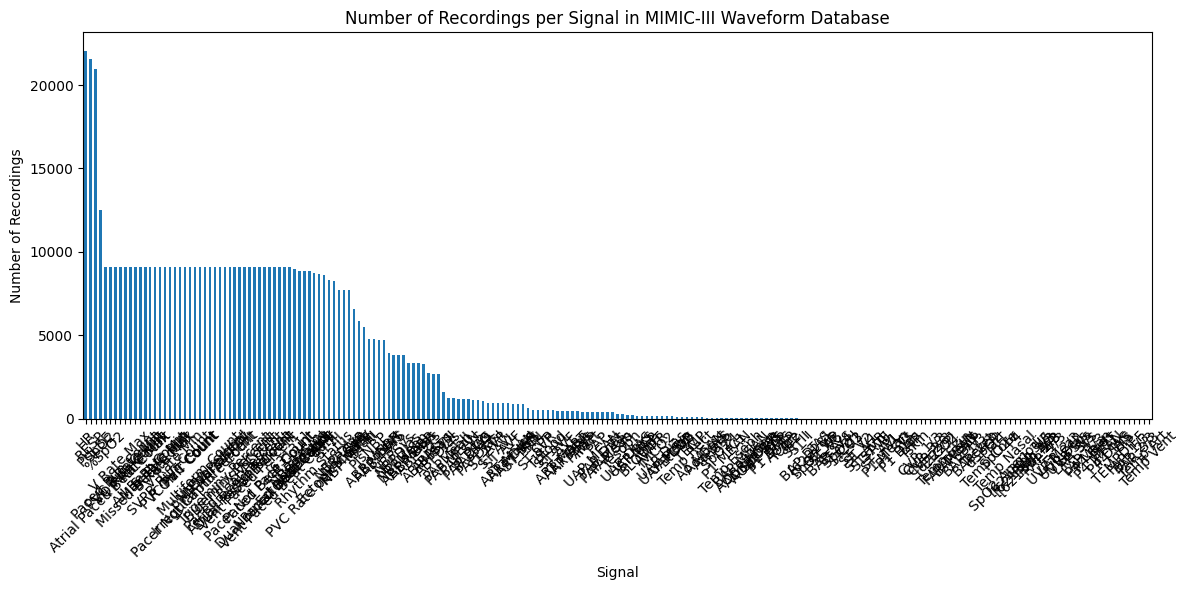

In [16]:
# number of recordings per signal
signal_counts = numerics_df['signal'].value_counts()
print("Number of recordings per signal:")
print(signal_counts)

# visualize it in a bar chart
import matplotlib.pyplot as plt
signal_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Recordings per Signal in MIMIC-III Waveform Database')
plt.xlabel('Signal')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Signals with more than 5000 recordings: 57


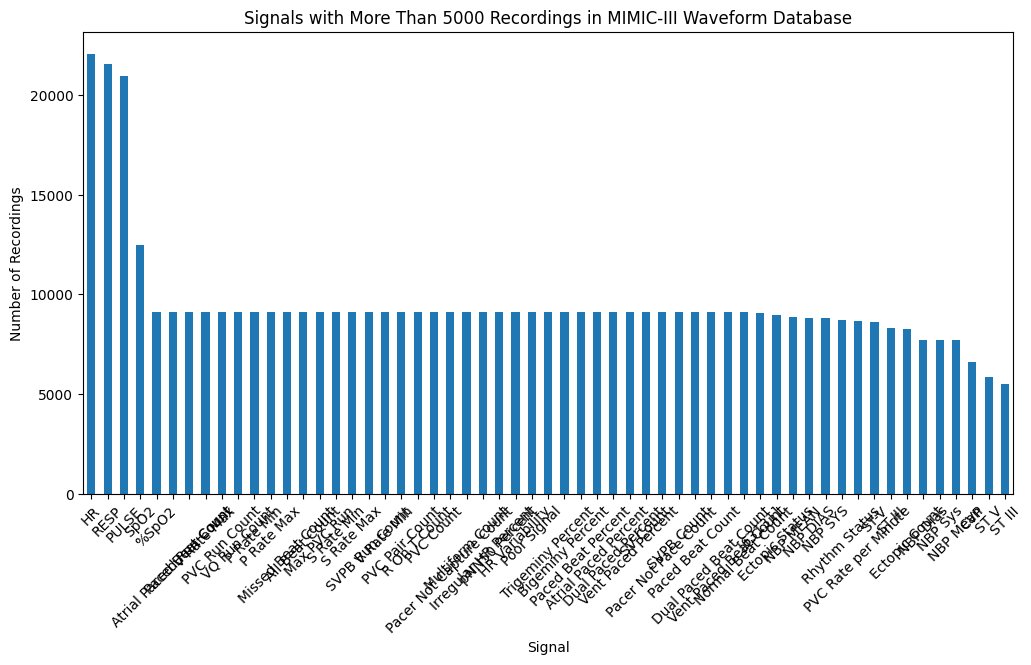

In [17]:
# filter for signals with more than 5000 recordings
filtered_signals = signal_counts[signal_counts > 5000]
print(f"Signals with more than 5000 recordings: {len(filtered_signals)}")
filtered_signals.plot(kind='bar', figsize=(12, 6))
plt.title('Signals with More Than 5000 Recordings in MIMIC-III Waveform Database')
plt.xlabel('Signal')
plt.ylabel('Number of Recordings')
plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()

In [18]:
def visualize_signal_durations(signal_name, vizualize=True):
    signal_data = numerics_df[numerics_df['signal'] == signal_name]
    signal_data = signal_data.copy()
    signal_data["duration_hours"] = signal_data['duration_seconds'] / 3600

    print(f"{signal_name} has {len(signal_data)} recordings.")
    print(f"Recordings longer than 1.5 hours: {len(signal_data[signal_data['duration_hours']>1.5])}")
    print(f"Number of patients with recordings longer than 1.5 hours: {len(signal_data[signal_data['duration_hours']>1.5]['subject'].unique())}")

    if vizualize:
        plt.figure(figsize=(12, 6))
        plt.hist(signal_data['duration_hours'], bins=50, alpha=0.7)
        plt.title(f'Duration of {signal_name} Signals in MIMIC-III Waveform Database')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    return len(signal_data[signal_data['duration_hours']>1.5]['subject'].unique())

HR has 22055 recordings.
Recordings longer than 1.5 hours: 20337
Number of patients with recordings longer than 1.5 hours: 10183


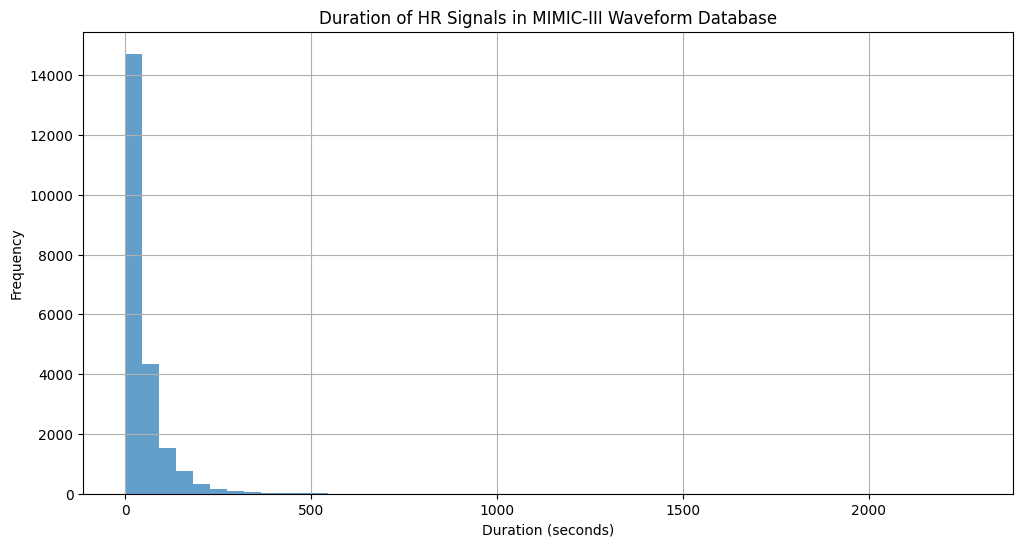

RESP has 21562 recordings.
Recordings longer than 1.5 hours: 19927
Number of patients with recordings longer than 1.5 hours: 9998


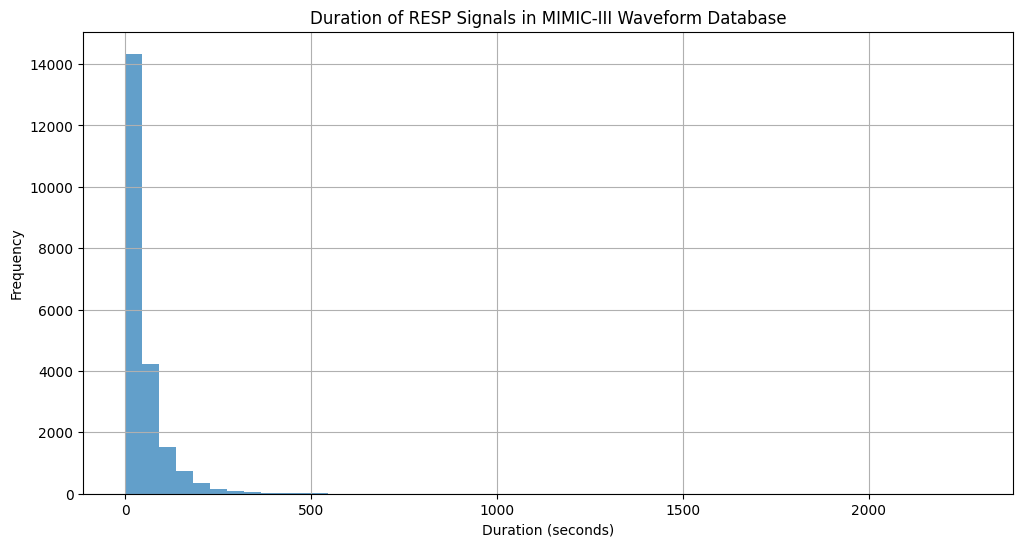

SpO2 has 12484 recordings.
Recordings longer than 1.5 hours: 11486
Number of patients with recordings longer than 1.5 hours: 6591


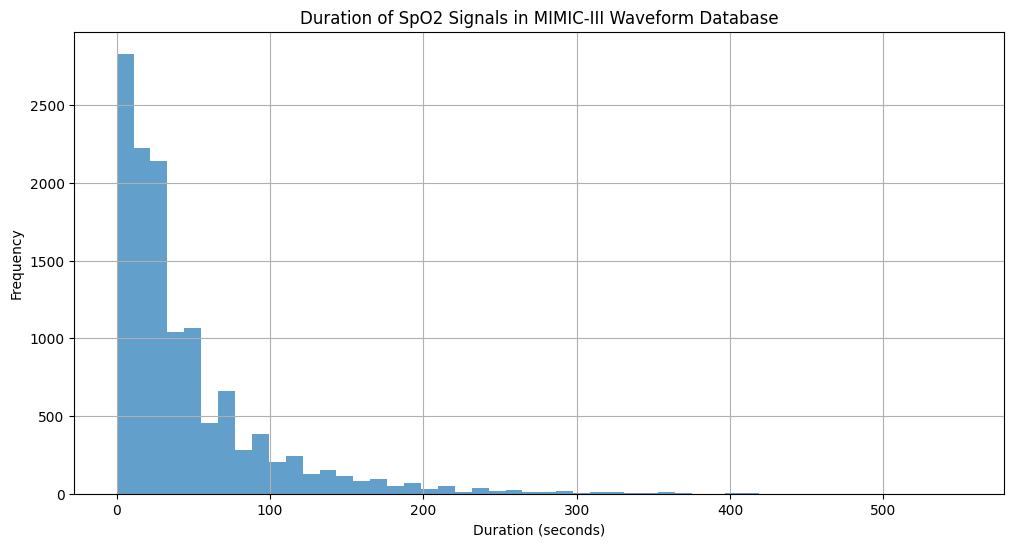

%SpO2 has 9115 recordings.
Recordings longer than 1.5 hours: 8433
Number of patients with recordings longer than 1.5 hours: 4301


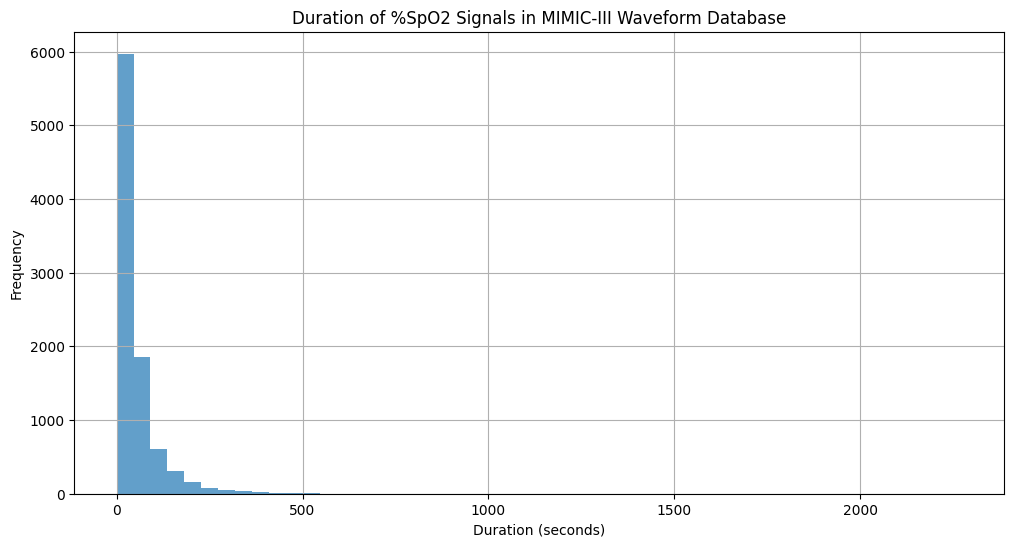

ABP has 3315 recordings.
Recordings longer than 1.5 hours: 3261
Number of patients with recordings longer than 1.5 hours: 2076


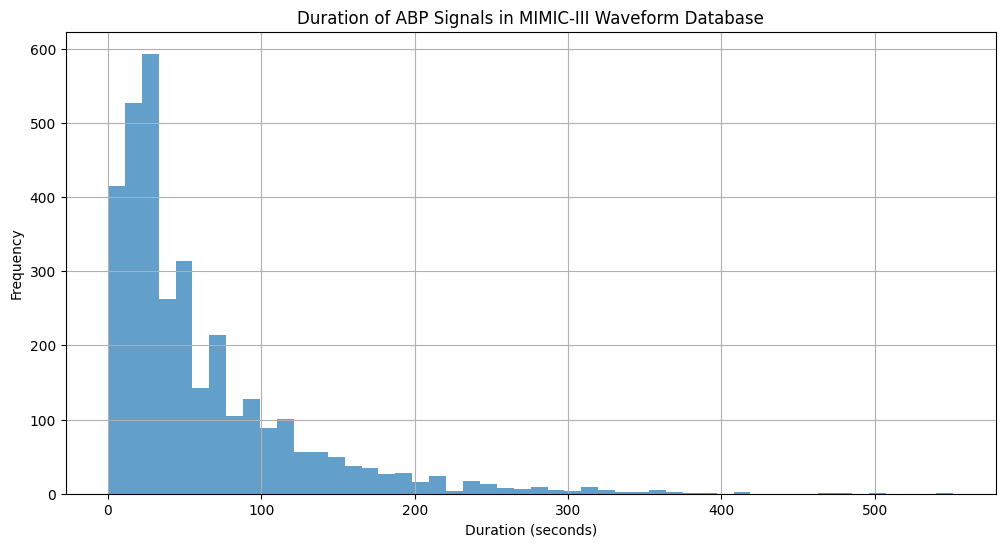

NBPMean has 3840 recordings.
Recordings longer than 1.5 hours: 3345
Number of patients with recordings longer than 1.5 hours: 1986


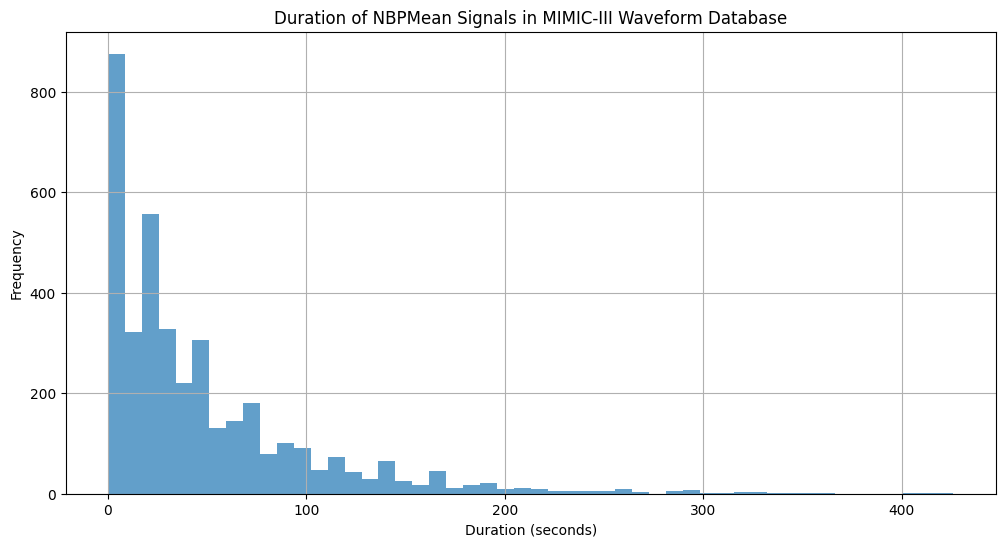

NBP MEAN has 8840 recordings.
Recordings longer than 1.5 hours: 8236
Number of patients with recordings longer than 1.5 hours: 4251


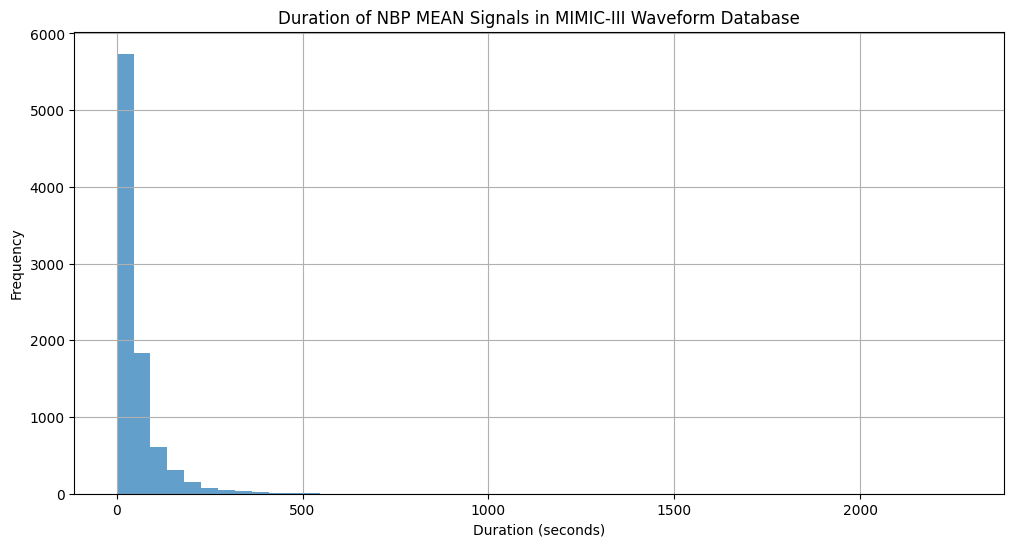

ABP MEAN has 4759 recordings.
Recordings longer than 1.5 hours: 4410
Number of patients with recordings longer than 1.5 hours: 2425


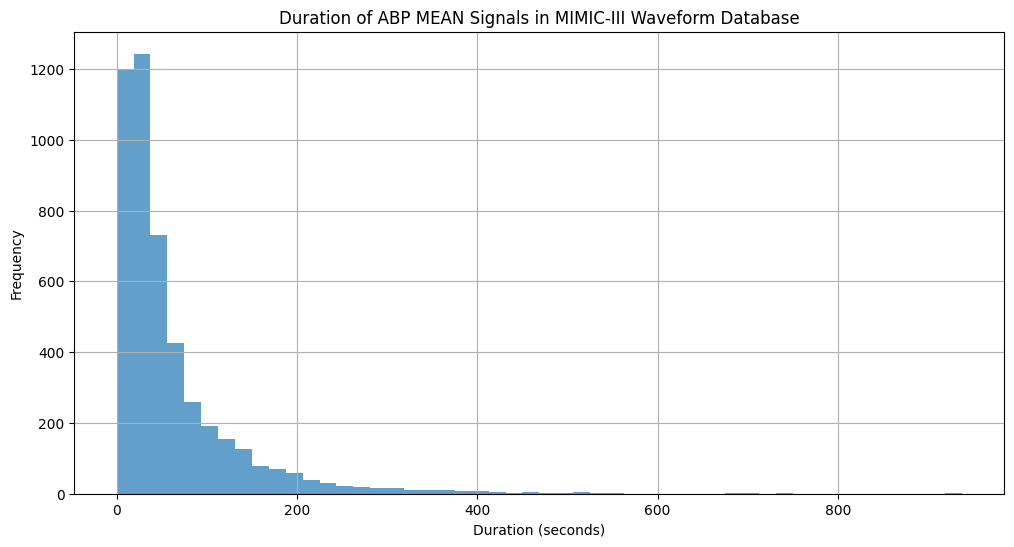

ART Mean has 492 recordings.
Recordings longer than 1.5 hours: 481
Number of patients with recordings longer than 1.5 hours: 392


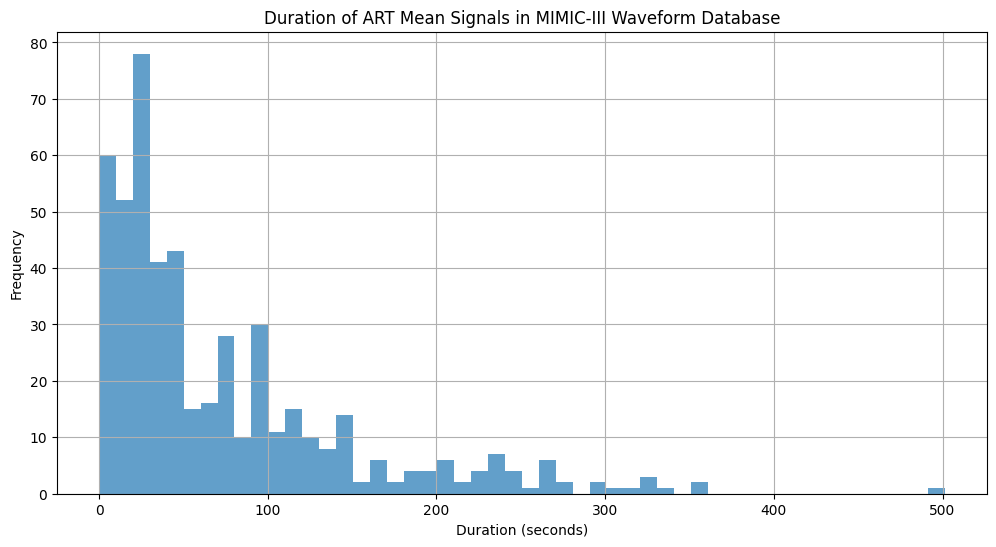

In [19]:
for signal in ["HR", "RESP", "SpO2", "%SpO2", "ABP", "NBPMean",'NBP MEAN', 'ABP MEAN', "ART Mean"]:
    visualize_signal_durations(signal)

From Literature and Jonas Requirements (that we also requested from Philips, we are interested in the following Signals:

    Philips Patient Monitor Intellivue X3 and MX750
    -non-invasive blood pressure (NIBP) (mean arterial pressure (MAP))
    -oxygen saturation (SpO2)
    -electrocardiogram (ECG)
    -invasive blood pressure (if available) (systolic and diastolic)
    Hamilton-C6
    -FiO2
    -CO2 partial pressure
    -airway average/peak pressure
    -Positive End Expiratory Pressure (PEEP)
    -tidal volume
    -Respiratory minute volume
    -respiratory rate
    -I:E ratio
    -compliance (dynamic and static)
    -resistance
    -Mode of ventilation


Should we add the temperature???

In [20]:
# for now let's limit to anything that is heart rate, respiratory rate, blood pressure, oxygen saturation
interesting_signals = ['HR', # heart rate
 'ABPSys', 'ABPDias', 'ABPMean', # blood pressure
 'RESP', # respiratory rate
'SpO2', '%SpO2', # oxygen saturation
 'NBPMean', 'NBP Mean', 'NBP MEAN', 'ABP MEAN', 'ART Mean', # mean non invasive blood pressure
'AOBP', 'AOBP Sys', 'AOBP Dias', 'AOBP Mean', 'ABP SYS', 'ABP DIAS',  'ABP',
 'ABP Sys', 'ABP Dias', 'ABP Mean', 
 'SpO2 L',  'SpO2 R', 'SpO2_AP',
 'ART SYS', 'ART DIAS', 'ART MEAN', 'BAP SYS', 'BAP DIAS', 'BAP MEAN',
'SpO2 r', 'SpO2 l']

In [21]:
signal_sample_count = {}
for signal in interesting_signals:
    number_samples = visualize_signal_durations(signal, vizualize=False)
    signal_sample_count[signal] = number_samples

HR has 22055 recordings.
Recordings longer than 1.5 hours: 20337
Number of patients with recordings longer than 1.5 hours: 10183
ABPSys has 2681 recordings.
Recordings longer than 1.5 hours: 2390
Number of patients with recordings longer than 1.5 hours: 1386
ABPDias has 2678 recordings.
Recordings longer than 1.5 hours: 2389
Number of patients with recordings longer than 1.5 hours: 1385
ABPMean has 2730 recordings.
Recordings longer than 1.5 hours: 2433
Number of patients with recordings longer than 1.5 hours: 1410
RESP has 21562 recordings.
Recordings longer than 1.5 hours: 19927
Number of patients with recordings longer than 1.5 hours: 9998
SpO2 has 12484 recordings.
Recordings longer than 1.5 hours: 11486
Number of patients with recordings longer than 1.5 hours: 6591
%SpO2 has 9115 recordings.
Recordings longer than 1.5 hours: 8433
Number of patients with recordings longer than 1.5 hours: 4301
NBPMean has 3840 recordings.
Recordings longer than 1.5 hours: 3345
Number of patients wit

In [22]:
# sort signal_sample_count by number of samples
signal_sample_count = dict(sorted(signal_sample_count.items(), key=lambda item: item[1], reverse=True))
print("Number of patients with recordings longer than 1.5 hours for interesting signals:")
for signal, count in signal_sample_count.items():
    print(f"{signal}: {count}")

Number of patients with recordings longer than 1.5 hours for interesting signals:
HR: 10183
RESP: 9998
SpO2: 6591
NBP Mean: 4457
%SpO2: 4301
NBP MEAN: 4251
ABP MEAN: 2425
ABP SYS: 2404
ABP DIAS: 2404
ABP: 2076
ABP Sys: 2070
ABP Dias: 2070
ABP Mean: 2070
NBPMean: 1986
ABPMean: 1410
ABPSys: 1386
ABPDias: 1385
ART MEAN: 437
ART SYS: 418
ART DIAS: 418
ART Mean: 392
SpO2 L: 48
AOBP Sys: 34
AOBP Dias: 34
AOBP Mean: 34
AOBP: 30
SpO2 R: 28
BAP MEAN: 11
SpO2 l: 9
BAP SYS: 6
BAP DIAS: 6
SpO2 r: 5
SpO2_AP: 4


In [ ]:
from pprint import pprint

# aggregate the stats for interesting signals
interesting_stats = {
    "heart rate":{
        "signals": ["HR"],
        "number_samples" : signal_sample_count["HR"],
    },
    "respiratory rate":{
        "signals": ["RESP"],
        "number_samples" : signal_sample_count["RESP"],
    },
    "oxygen saturation":{
        "signals": ["SpO2", "%SpO2"],
        "number_samples" : sum([signal_sample_count[signal] for signal in ["SpO2", "%SpO2", "SpO2 L", "SpO2 R", "SpO2_AP", "SpO2 r", "SpO2 l"]]),
    },
    "mean_blood_pressure":{
        "signals": ["NBPMean", "NBP Mean", "NBP MEAN"],
        "number_samples" : sum([signal_sample_count[signal] for signal in ["ABPMean", "NBPMean", "NBP Mean", "NBP MEAN", "ABP MEAN", "ART Mean"]]),
    }
}

pprint(interesting_stats, sort_dicts=False)

{'heart rate': {'signals': ['HR'], 'number_samples': 10183},
 'respiratory rate': {'signals': ['RESP'], 'number_samples': 9998},
 'oxygen saturation': {'signals': ['SpO2', '%SpO2'], 'number_samples': 10986},
 'mean_blood_pressure': {'signals': ['ABPMean',
                                     'NBPMean',
                                     'NBP Mean',
                                     'NBP MEAN',
                                     'ABP MEAN',
                                     'ART Mean'],
                         'number_samples': 14921}}


In [23]:
# get "subject" with a signal longer than 3600 seconds 
def get_subjects_with_signal_longer_than(duration_seconds, interesting_stats):

    suitable_records = []

    # filter out records that are shorter than 3600 seconds
    long_signal_data = numerics_df[numerics_df['duration_seconds'] > duration_seconds]
    long_signal_data = long_signal_data[long_signal_data['signal'].isin(interesting_stats['heart rate']['signals'] + interesting_stats['respiratory rate']['signals'] + interesting_stats['oxygen saturation']['signals'] + interesting_stats['mean_blood_pressure']['signals'])]
    records = long_signal_data["record_id"].unique()
    print(len(records), "records with a signal longer than", duration_seconds, "seconds.")

    i = 0
    # check if at least one of the "signals" in the values of interesting_stats exists for the record
    for record in records:
        record_signals = long_signal_data[long_signal_data['record_id'] == record]['signal'].unique()

        # drop all record_signals that are not in the interesting_stats
        record_signals = [signal for signal in record_signals if signal in interesting_stats['heart rate']['signals'] or
                          signal in interesting_stats['respiratory rate']['signals'] or
                          signal in interesting_stats['oxygen saturation']['signals'] or
                          signal in interesting_stats['mean_blood_pressure']['signals']]
        

        contains_key = {}
        for key, value in interesting_stats.items():
            contains_key[key] = False
            if any(signal in value['signals'] for signal in record_signals):
                contains_key[key] = True

        if all(contains_key.values()):
            suitable_records.append(record)

        i = i+1
        if i % 1000 == 0:
            print(f"Processed {i} records out of {len(records)}")

    return suitable_records

In [ ]:
suitable_records = get_subjects_with_signal_longer_than(3600, interesting_stats=interesting_stats)

print(f"Number of records with at least one signal longer than 3600 seconds: {len(suitable_records)}")

20754 records with a signal longer than 3600 seconds.
Processed 1000 records out of 20754
Processed 2000 records out of 20754
Processed 3000 records out of 20754
Processed 4000 records out of 20754
Processed 5000 records out of 20754
Processed 6000 records out of 20754
Processed 7000 records out of 20754
Processed 8000 records out of 20754
Processed 9000 records out of 20754
Processed 10000 records out of 20754
Processed 11000 records out of 20754
Processed 12000 records out of 20754
Processed 13000 records out of 20754
Processed 14000 records out of 20754
Processed 15000 records out of 20754
Processed 16000 records out of 20754
Processed 17000 records out of 20754
Processed 18000 records out of 20754
Processed 19000 records out of 20754
Processed 20000 records out of 20754
Number of records with at least one signal longer than 3600 seconds: 19528


In [131]:
# save suitable_records as a pickle file
output_file = 'mimic3wdb-matched_suitable_records.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(suitable_records, f)

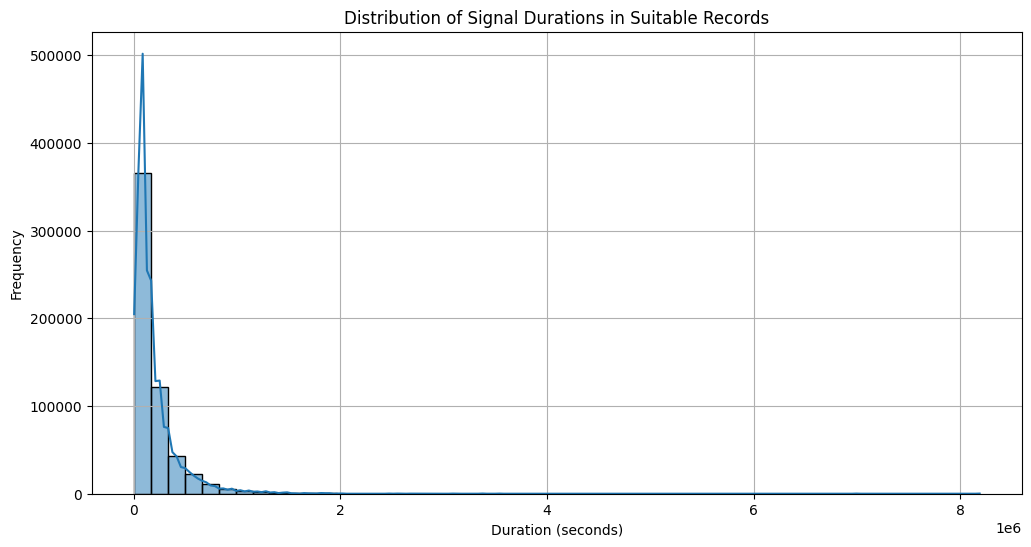

In [132]:
# plot distribution of duration of signals in suitable_records
import seaborn as sns
suitable_signal_data = numerics_df[numerics_df['record_id'].isin(suitable_records)]
plt.figure(figsize=(12, 6))
sns.histplot(suitable_signal_data['duration_seconds'], bins=50, kde=True)
plt.title('Distribution of Signal Durations in Suitable Records')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [135]:
# only keep one entry for each record_id
suitable_signal_data = suitable_signal_data.drop_duplicates(subset=['record_id', 'signal'])
# sum of durations of signals in suitable_records
total_duration = suitable_signal_data['duration_seconds'].sum()
print(f"Total duration of signals in suitable records: {total_duration} seconds ({total_duration / 3600:.2f} hours) or ({total_duration / (3600 * 24):.2f} days)")

Total duration of signals in suitable records: 111557004954.80702 seconds (30988056.93 hours) or (1291169.04 days)


In [24]:
from pprint import pprint

# aggregate the stats for interesting signals
interesting_stats = {
    "heart rate":{
        "signals": ["HR"],
        "number_samples" : signal_sample_count["HR"],
    },
    "respiratory rate":{
        "signals": ["RESP"],
        "number_samples" : signal_sample_count["RESP"],
    },
    "oxygen saturation":{
        "signals": ["SpO2", "%SpO2"],
        "number_samples" : sum([signal_sample_count[signal] for signal in ["SpO2", "%SpO2", "SpO2 L", "SpO2 R", "SpO2_AP", "SpO2 r", "SpO2 l"]]),
    },
    "mean_noninvasive_blood_pressure":{
        "signals": ["NBPMean", "NBP Mean", "NBP MEAN"],
        "number_samples" : sum([signal_sample_count[signal] for signal in ["ABPMean", "NBPMean", "NBP Mean", "NBP MEAN"]]),
    }
    ,
    "mean_arterial_blood_pressure":{
        "signals": ["ABPMean", "NBP Mean", "NBP MEAN"],
        "number_samples" : sum([signal_sample_count[signal] for signal in ["ABPMean", "ABP Mean", "ABP MEAN", "ABP MEAN", "ART Mean"]]),
    }
}

pprint(interesting_stats, sort_dicts=False)

{'heart rate': {'signals': ['HR'], 'number_samples': 10183},
 'respiratory rate': {'signals': ['RESP'], 'number_samples': 9998},
 'oxygen saturation': {'signals': ['SpO2', '%SpO2'], 'number_samples': 10986},
 'mean_noninvasive_blood_pressure': {'signals': ['NBPMean',
                                                 'NBP Mean',
                                                 'NBP MEAN'],
                                     'number_samples': 12104},
 'mean_arterial_blood_pressure': {'signals': ['ABPMean',
                                              'NBP Mean',
                                              'NBP MEAN'],
                                  'number_samples': 8722}}


In [26]:
# get "subject" with a signal longer than 3600 seconds 
def get_subjects_with_signal_longer_than_with_abp(duration_seconds, interesting_stats):

    suitable_records = []

    # filter out records that are shorter than 3600 seconds
    long_signal_data = numerics_df[numerics_df['duration_seconds'] > duration_seconds]
    long_signal_data = long_signal_data[long_signal_data['signal'].isin(interesting_stats['heart rate']['signals'] + 
                                                                        interesting_stats['respiratory rate']['signals'] + 
                                                                        interesting_stats['oxygen saturation']['signals'] + 
                                                                        interesting_stats['mean_noninvasive_blood_pressure']['signals'] +
                                                                        interesting_stats['mean_arterial_blood_pressure']['signals'])]
    records = long_signal_data["record_id"].unique()
    print(len(records), "records with a signal longer than", duration_seconds, "seconds.")

    i = 0
    # check if at least one of the "signals" in the values of interesting_stats exists for the record
    for record in records:
        record_signals = long_signal_data[long_signal_data['record_id'] == record]['signal'].unique()

        # drop all record_signals that are not in the interesting_stats
        record_signals = [signal for signal in record_signals if signal in interesting_stats['heart rate']['signals'] or
                          signal in interesting_stats['respiratory rate']['signals'] or
                          signal in interesting_stats['oxygen saturation']['signals'] or
                          signal in interesting_stats['mean_noninvasive_blood_pressure']['signals'] or
                          signal in interesting_stats['mean_arterial_blood_pressure']['signals']]
        

        contains_key = {}
        for key, value in interesting_stats.items():
            contains_key[key] = False
            if any(signal in value['signals'] for signal in record_signals):
                contains_key[key] = True

        if all(contains_key.values()):
            suitable_records.append(record)

        i = i+1
        if i % 1000 == 0:
            print(f"Processed {i} records out of {len(records)}")

    return suitable_records

In [29]:
suitable_records = get_subjects_with_signal_longer_than_with_abp(5400, interesting_stats=interesting_stats)

print(f"Number of records with at least one signal longer than 5400 seconds (1,5 hours): {len(suitable_records)}")

20349 records with a signal longer than 5400 seconds.
Processed 1000 records out of 20349
Processed 2000 records out of 20349
Processed 3000 records out of 20349
Processed 4000 records out of 20349
Processed 5000 records out of 20349
Processed 6000 records out of 20349
Processed 7000 records out of 20349
Processed 8000 records out of 20349
Processed 9000 records out of 20349
Processed 10000 records out of 20349
Processed 11000 records out of 20349
Processed 12000 records out of 20349
Processed 13000 records out of 20349
Processed 14000 records out of 20349
Processed 15000 records out of 20349
Processed 16000 records out of 20349
Processed 17000 records out of 20349
Processed 18000 records out of 20349
Processed 19000 records out of 20349
Processed 20000 records out of 20349
Number of records with at least one signal longer than 5400 seconds (1,5 hours): 17592


In [31]:
# save suitable_records as a pickle file
import pickle
output_file = 'mimic3wdb-matched_suitable_records_with_mean_abp.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(suitable_records, f)

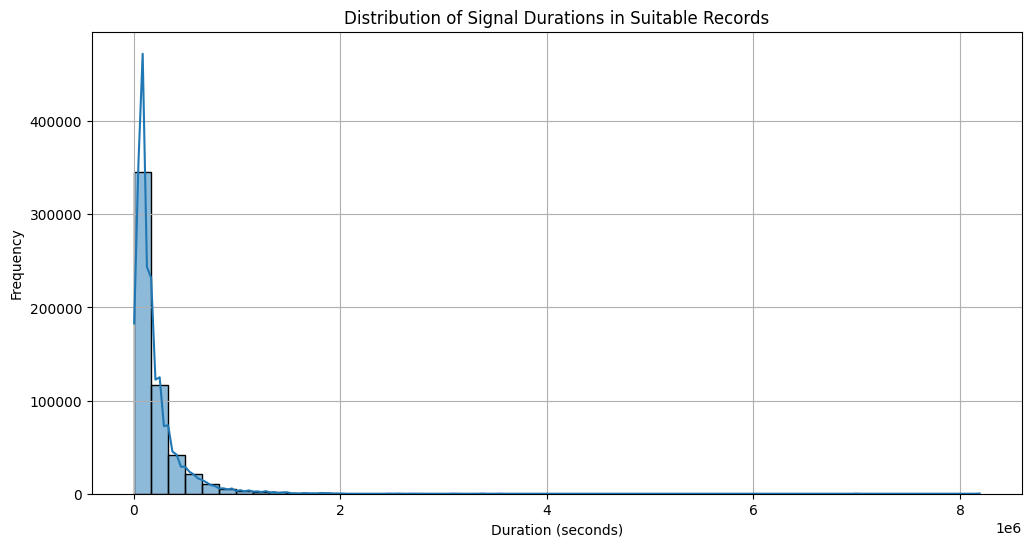

In [32]:
import seaborn as sns
suitable_signal_data = numerics_df[numerics_df['record_id'].isin(suitable_records)]
plt.figure(figsize=(12, 6))
sns.histplot(suitable_signal_data['duration_seconds'], bins=50, kde=True)
plt.title('Distribution of Signal Durations in Suitable Records')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [33]:
# only keep one entry for each record_id
suitable_signal_data = suitable_signal_data.drop_duplicates(subset=['record_id', 'signal'])
# sum of durations of signals in suitable_records
total_duration = suitable_signal_data['duration_seconds'].sum()
print(f"Total duration of signals in suitable records: {total_duration} seconds ({total_duration / 3600:.2f} hours) or ({total_duration / (3600 * 24):.2f} days)")

Total duration of signals in suitable records: 108666576258.8141 seconds (30185160.07 hours) or (1257715.00 days)


In [34]:
# get number of unique subject_id in numerics_df
unique_subjects = numerics_df['subject'].unique()
print(f"Number of unique subjects in the numerics dataset: {len(unique_subjects)}")

Number of unique subjects in the numerics dataset: 10269


# Data Exploration

- get patient ids
    - get number of patients that are ventilated and patients that are not ventilated
- get all unique vitals that are recorded
- select the ones, already known to be relevant from literature
- see how many records conain all of them

In [15]:
# number of subjects in the database
print(f"Number of subjects in the '{database_name}' database: {len(subjects)}")

Number of subjects in the 'mimic3wdb-matched/1.0' database: 10282


In [61]:
subject_signal_dict = {}

In [62]:
for subject in subjects:
    uniuqe_signals = set()
    records = []
    studies = wfdb.get_record_list(f'{database_name}/{subject}')

    for study in studies:
            records.append(Path(f'{subject}{study}'))

    for record in records:
        if not subject.split('/')[1] in record.name and '_0001' in record.name:
            record_dir = f'{database_name}/{subject}'
            record_name = record.name.replace(subject.split('/')[1] + '-', '')
            record_data = wfdb.rdheader(record_name, pn_dir=record_dir, rd_segments=True)
            uniuqe_signals.update(record_data.sig_name)
            #break

    subject_signal_dict[subject] = uniuqe_signals
            


In [63]:
# store a python dictionary
import pickle
with open('subject_signal_dict.pkl', 'wb') as f:
    pickle.dump(subject_signal_dict, f)

In [64]:
# aggregate the signals for all subjects
all_signals = set()
for subject in subjects:
    all_signals.update(subject_signal_dict[subject])
print(f"Number of unique signals in the '{database_name}' database: {len(all_signals)}")
print(f"Unique signals:")
for signal in all_signals:
    print(signal)

Number of unique signals in the 'mimic3wdb-matched/1.0' database: 33
Unique signals:
P1
II
IC1
MCL
aVL
PLETH L
ECG
AVL
RAP
IC2
PLETHr
I
aVF
PAP
UVP
UAP
V
ICP
PLETH
AVR
MCL1
CVP
RESP
???
ART
ABP
PLETH R
Ao
AVF
AOBP
CO2
III
aVR


No SpO2 in here


- ECG
- PAP (partial arterial pressure?)
- resp?
- ABP (arterial blood pressure?)